In [355]:
!which python
!whoami 
!hostname
!pwd

/home/farshed.abdukhakimov/miniconda3/envs/main/bin/python
farshed.abdukhakimov
srv-01
/home/farshed.abdukhakimov/projects/twin-polyak/experiments


In [543]:
%load_ext autoreload
%autoreload 2

import os
import datetime
from collections import defaultdict

import torch
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import sklearn
import scipy 
import matplotlib.pyplot as plt

import sps
import sls

import utils
from solve_binary_libsvm import solve_binary_libsvm


from dotenv import load_dotenv
load_dotenv()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


True

In [576]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

In [577]:
dataset_name = "a1a"
trainX, trainY, testX, testY = utils.get_libsvm(dataset_name, test_split=0.0)

trainY = utils.map_classes_to(trainY, [0.0, 1.0])
testY = utils.map_classes_to(testY, [0.0, 1.0])

train_data, train_target = sklearn.preprocessing.normalize(trainX, norm='l2', axis=1), trainY
test_data, test_target = sklearn.preprocessing.normalize(testX, norm='l2', axis=1), testY

b = solve_binary_libsvm(train_data, train_target, test_data, test_target)
train_f_star, train_x_star, test_f_star, test_x_star = b["train/f_star"], b["train/x_star"], b["test/f_star"], b["test/x_star"]

L = (0.25 / train_data.shape[0]) * scipy.sparse.linalg.norm(train_data.T @ train_data, ord=2)

# batch_size = train_data.shape[0]
batch_size = 128

train_data = torch.tensor(trainX.toarray(), dtype=torch.float)
train_target = torch.tensor(trainY, dtype=torch.float)

train_data = train_data.to(torch.get_default_dtype())
train_target = train_target.to(torch.get_default_dtype())
train_load = TensorDataset(train_data, train_target)
train_dataloader = DataLoader(train_load, batch_size=batch_size, shuffle=True)

test_data = torch.tensor(testX.toarray(), dtype=torch.float)
test_target = torch.tensor(testY, dtype=torch.float)

test_data = test_data.to(torch.get_default_dtype())
test_target = test_target.to(torch.get_default_dtype())
test_load = TensorDataset(test_data, test_target)
test_dataloader = DataLoader(test_load, batch_size=batch_size, shuffle=False)
        
print(f"{L=}")
print(f"{1/L=}")
print(f"{np.unique(train_target)=}")

L=0.11295985172235656
1/L=8.852702838685508
np.unique(train_target)=array([0., 1.], dtype=float32)


In [661]:
def mean_max_min(l):
    max_length = max(len(sublist) for sublist in l)
    
    mean_line = []
    max_line = []
    min_line = []
    for i in range(max_length):
        values_at_position = [sublist[i] for sublist in l if i < len(sublist)]
        mean_line.append(np.mean(values_at_position))
        max_line.append(np.max(values_at_position))
        min_line.append(np.min(values_at_position))

    return mean_line, max_line, min_line


def plotter(histories: dict,
                  colors=list(plt.cm.colors.XKCD_COLORS.keys()) + list(plt.cm.colors.BASE_COLORS), 
                  linestyles=["-" for _ in range(20)], 
                  linewidths=[1.5 for _ in range(20)], 
                  markers=[" " for _ in range(20)], 
                  markeredgecolor="dimgrey", 
                  markersize=8, 
                  alphas=[1.0 for _ in range(20)], 
                  f_star=None, suptitle=None, 
                  metrics=["train/loss", "train/grad_norm_sq", "train/acc", "lr"], y_scales=["log", "log", "linear", "log"],
                  mov_ave=[False for _ in range(20)],
                  x_labels=None, y_labels=None, x_labels_fs=16, y_labels_fs=16,
                  acc_ylim=None,
                  threshold=1e-10, xlims=None, tight_layout=True, legend_below=False,
                  filename=None):
    
    fig, ax = plt.subplots(1, len(metrics), figsize=(len(metrics) * 4, 4))
    if suptitle is not None:
        fig.suptitle(suptitle, fontsize=16)
    
    for (label, history), c, ls, lw, m, alpha in zip(histories.items(), colors, linestyles, linewidths, markers, alphas):
        
        steps_per_epoch = len(history[0]["lr"]) / len(history[0]["train/loss"])
        
        for (ax_idx, metric), apply_ma in zip(enumerate(metrics), mov_ave):
            
            if metric in ["train/loss", "test/loss"]:
                if apply_ma:
                    res = [utils.moving_average(x[metric] - f_star, len(x[metric]) // 10) for x in history]
                else:
                    res = [x[metric] - f_star for x in history]
            else:
                if apply_ma:
                    res = [utils.moving_average(x[metric], len(x[metric]) // 10) for x in history]
                else:
                    res = [x[metric] for x in history]
            
            mean_line, max_line, min_line = mean_max_min(res)
            if metric == "lr":
                x = np.linspace(0, len(mean_line)/steps_per_epoch - 1, len(mean_line))
            else:
                x = np.linspace(0, len(mean_line) - 1, len(mean_line))
            
            markevery = [0,] + [x + np.random.randint(0, 10) for x in range(len(mean_line) // 5, len(mean_line) - 10, len(mean_line) // 5)]
                
            
            lbl = None
            if ax_idx == len(metrics) - 1:
                lbl = label
                
            ax[ax_idx].fill_between(x, max_line, min_line, color=c, alpha=0.2)
            ax[ax_idx].plot(x, mean_line, label=lbl, linestyle=ls, linewidth=lw, color=c, markevery=markevery, marker=m, markeredgecolor=markeredgecolor, markersize=markersize)   
            ax[ax_idx].set_yscale(y_scales[ax_idx])
            
            if metric == "test/acc" and acc_ylim:
                ax[ax_idx].set_ylim(bottom=acc_ylim)

    for i, xlabel, ylabel, _ in zip(range(4), x_labels, y_labels, metrics):
        ax[i].set_xlabel(xlabel, fontsize=x_labels_fs)
        ax[i].set_ylabel(ylabel, fontsize=y_labels_fs)
        ax[i].grid()
    
    if xlims is not None:
        ax[1].set_xlim(right=xlims[1])
    
    if legend_below:
        # Put a legend below current axis
        fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.02), fancybox=True, shadow=True, ncol=len(histories))
    else:
        fig.legend()
    
    
    if tight_layout:
        fig.tight_layout()
        
    if filename is not None:
        directory = "plots/" + datetime.datetime.today().strftime("%d-%m-%Y")
        if not os.path.exists(directory):
            os.makedirs(directory)
        fig.savefig(directory + "/" + filename)
    else:
        fig.show()

In [662]:
def train_optimizer(
                    optimizer: torch.nn.Module, 
                    epochs: int, 
                    seed: int = 0,
                    **optimizer_kwargs
                    ) -> dict:
    
    torch.manual_seed(seed)
    
    model = torch.nn.Linear(in_features=train_data.shape[1],
                            out_features=1,
                            device=device 
                            )
    optimizer = optimizer(model.parameters(), **optimizer_kwargs)
    
    loss_function = torch.nn.BCEWithLogitsLoss()

    history = defaultdict(list)

    for epoch in range(epochs):
        logits = model(train_data)
        loss = loss_function(logits, train_target.unsqueeze(1))
        history["train/loss"].append(loss.item())
        
        for i, (batch_data, batch_target) in enumerate(train_dataloader):
            batch_data = batch_data.to(device)
            batch_target = batch_target.to(device).unsqueeze(1)
            logits = model(batch_data)
            closure = lambda : loss_function(logits, batch_target)

            if isinstance(optimizer, sps.Sps):
                loss = closure()
                optimizer.zero_grad()
                loss.backward()
                optimizer.step(loss=loss)
                history["lr"].append(optimizer.state["step_size"])
            elif isinstance(optimizer, sls.Sls):
                optimizer.zero_grad()
                optimizer.step(closure=closure)
                history["lr"].append(optimizer.state["step_size"])
            elif isinstance(optimizer, DecSPS):
                loss = closure()
                optimizer.zero_grad()
                loss.backward()
                optimizer.step(closure=closure)
                history["lr"].append(optimizer.step_size)
            else:
                loss = closure()
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                history["lr"].append(optimizer.param_groups[0]["lr"])
    return history


In [663]:
from torch import Tensor
from typing import Any, Dict, Iterable, List

class TwinPolyak(torch.optim.Optimizer):
    
    def __init__(self, params: Iterable[Tensor] | Iterable[Dict[str, Any]], 
                 eps: float = 1e-8) -> None:
        
        self.step_size: float = 1.0
        
        defaults = dict(
            eps=eps,
            )

        super().__init__(params, defaults)
        
    def step(self, loss_diff: float):

        for group in self.param_groups:
            
            eps: float = group["eps"]
            
            grad_norm_squared: float = 0.0
            for p in group["params"]:
                grad_norm_squared += p.grad.data.mul(p.grad.data).sum()
            
            self.step_size = loss_diff / (0.5 * grad_norm_squared + eps)

            # Update parameters
            with torch.no_grad():
                for p in group["params"]:
                    p.sub_(p.grad.data, alpha=self.step_size)
                    
                    
class DecSPS(torch.optim.Optimizer):
    
    def __init__(self, params: Iterable[Tensor] | Iterable[Dict[str, Any]], 
                 c_0: float = 1.0,
                 eta_max: float = 10.0,
                 f_star: float = 0.0,
                 eps: float = 1e-8) -> None:
        
        self.step_size: float = eta_max
        self.c_0: float = c_0
        self.c: float = c_0
        self.c_prev: float = c_0
        self.eta_max: float = eta_max
        self.f_star: float = f_star
    
        self._step_t: Tensor = torch.tensor(0)
        
        defaults = dict(
            c_0=c_0,
            c=c_0,
            eta_max=eta_max,
            eps=eps,
            )

        super().__init__(params, defaults)
        
    def step(self, closure=None):
        loss = None 
        if closure is not None:
            with torch.enable_grad():
                loss = closure()
        else:
            raise ValueError("Closure must be provided for loss evaluation.")
                
        for group in self.param_groups:
            
            eps: float = group["eps"]
            
            c_prev: Tensor = torch.tensor(self.c)
            self.c = self.c_0 * torch.sqrt(self._step_t + 1)
            self._step_t += 1
            
            grad_norm_squared: float = 0.0
            for p in group["params"]:
                grad_norm_squared += p.grad.data.mul(p.grad.data).sum()
                
            polyak_lr = (loss - self.f_star) / (grad_norm_squared + eps)
            self.step_size = (torch.minimum(polyak_lr, c_prev * self.step_size) / self.c).item()

            # Update parameters
            with torch.no_grad():
                for p in group["params"]:
                    p.sub_(p.grad.data, alpha=self.step_size)
                    
        return loss

In [664]:
def train_twin_polyak(epochs: int,
                      seed: int = 0,
                      **optimizer_kwargs) -> dict:
    
    torch.manual_seed(seed)
    
    model_x = torch.nn.Linear(in_features=train_data.shape[1],
                            out_features=1,
                            device=device
                            )
    model_y = torch.nn.Linear(in_features=train_data.shape[1],
                            out_features=1,
                            device=device 
                            )

    optimizer_x = TwinPolyak(model_x.parameters(), **optimizer_kwargs)
    optimizer_y = TwinPolyak(model_y.parameters(), **optimizer_kwargs)
    
    loss_function = torch.nn.BCEWithLogitsLoss()

    history = defaultdict(list)
    
    for epoch in range(epochs):
        logits_x = model_x(train_data)
        loss_x = loss_function(logits_x, train_target.unsqueeze(1))
    
        logits_y = model_y(train_data)
        loss_y = loss_function(logits_y, train_target.unsqueeze(1))
         
        loss = loss_x if loss_x < loss_y else loss_y
        history["train/loss"].append(loss.item())
        
        for i, (batch_data, batch_target) in enumerate(train_dataloader):
            batch_data = batch_data.to(device)
            batch_target = batch_target.to(device).unsqueeze(1)

            logits_x = model_x(batch_data)
            logits_y = model_y(batch_data)
            
            loss_x = loss_function(logits_x, batch_target)
            loss_y = loss_function(logits_y, batch_target)

            if loss_x > loss_y:
                optimizer_x.zero_grad()
                loss_x.backward()
                optimizer_x.step(loss_diff=(loss_x - loss_y).item())
                history["lr"].append(optimizer_x.step_size)
            else:
                optimizer_y.zero_grad()
                loss_y.backward()
                optimizer_y.step(loss_diff=(loss_y - loss_x).item())
                history["lr"].append(optimizer_y.step_size)
    return history

In [669]:
epochs = 50
seed = 0

histories = dict()

In [ ]:
# lr = 0.5
# hist_sgd = train_optimizer(
#     optimizer=torch.optim.SGD,
#     epochs=epochs,
#     lr=lr,
# )
# histories[r"SGD, $\eta={0}$".format(lr)] = [hist_sgd]

# for eta_max in [1.0, 5.0, 10.0]:
#     hist_sps = train_optimizer(
#         optimizer=sps.Sps,
#         epochs=epochs,
#         eta_max=eta_max,
#         adapt_flag='constant',
#     )
#     histories[r"SPS$_{{max}}$, $\eta={0}$".format(eta_max)] = [hist_sps]

hist_sls = train_optimizer(
    optimizer=sls.Sls,
    epochs=epochs,
    reset_option=2,
)
histories["SLS"] = [hist_sls]

# hist_decsps = train_optimizer(
#     optimizer=DecSPS,
#     epochs=epochs,
# )
# histories["DecSPS"] = [hist_decsps]

# hist_stp = train_twin_polyak(
#     epochs=epochs,
# )    
# histories["STP"] = [hist_stp]

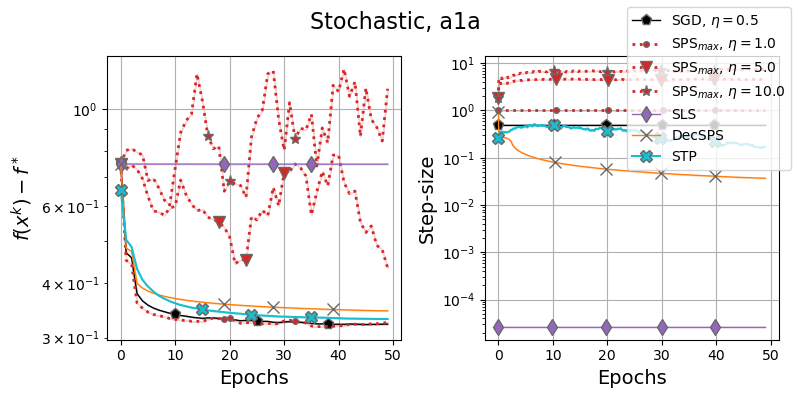

In [681]:
plotter(histories=histories, 
        colors=["black", "tab:red", "tab:red", "tab:red", "tab:purple", "tab:orange", "tab:cyan"],
        linestyles=["-", ":", ":", ":", "-", "-", "-"],
        linewidths=[1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.5],
        markers=["p", ".", "v", "*", "d", "x", "X"],
        markeredgecolor="dimgrey",
        markersize=8,
        alphas=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8],
        f_star=np.asarray(0.0), 
        x_labels=["Epochs", "Epochs", "Epochs", "Epochs"],
        y_labels=[r"$f(x^k) - f^*$", "Step-size", r"$\| \nabla f(x^k) \|^2$", "Test Accuracy", r"Step-size"],
        x_labels_fs=14, y_labels_fs=14,
        suptitle=f"Stochastic, {dataset_name}",
        metrics=["train/loss", "lr"],
        y_scales=["log", "log", "log"],
        mov_ave=[True, True, True, True],
        # threshold=0.0,
        # acc_ylim=0.7,
        # filename=f"{dataset_name}_stochastic_logreg_4.pdf",
        )

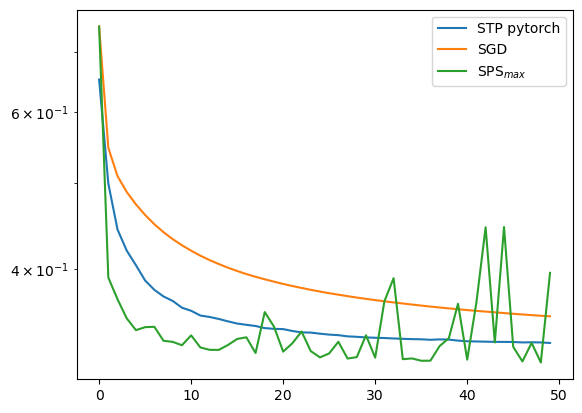

In [491]:
plt.semilogy(hist_stp["train/loss"], label="STP pytorch")
plt.semilogy(hist_sgd["train/loss"], label="SGD")
plt.semilogy(hist_sps["train/loss"], label=r"SPS$_{max}$")
plt.legend()

In [463]:
hist_np = utils.load_results(
    loss="logreg",
    setting="stochastic",
    dataset_name="a1a",
    batch_size=batch_size,
    n_epochs=200,
    optimizer="STP",
    lr="1_0",
    seed=0
)

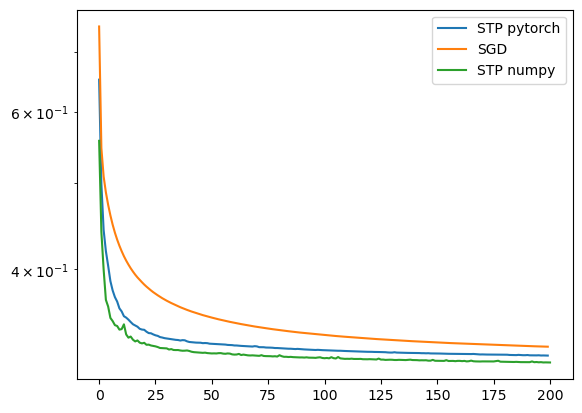

In [464]:
plt.semilogy(hist_stp["train/loss"], label="STP pytorch")
plt.semilogy(hist_sgd["train/loss"], label="SGD")
plt.semilogy(hist_np["train/loss"], label="STP numpy")
plt.legend()